## Climlab Project Master Program

In [1]:
! pip install climlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for climlab: filename=climlab-0.8.2-py3-none-any.whl size=171438 sha256=d372b4d1a50f70988b886bfbfcead834a756c752247df59fc6a9724c21db7f25
  Stored in directory: /root/.cache/pip/wheels/b8/de/bb/3a39e440567925a2df52134308d3cc424f69bbe4e854a3de35
Successfully built climlab


Step 1: Assign values to orbital elements and other constants
## <ins> NOTE: These value are to be changed based on your system </ins>

In [10]:
import numpy as np

typea = "s" # either seasonal (s) or annual (a)
num_orb = 365 # number of days(s)/orbits(a) to integrate over
orbits = np.arange(0,num_orb+1,1)

obl_omega = 10 # obliquity frequency
obl_amp = 10 # obliquity amplitude
obl_cnst = 20 # obliquity center value (Earth = 23.5)
obl_var = obl_cnst + obl_amp*np.sin(obl_omega*orbits) # assumes a sin wave variance in obliquity

ecc_omega = 20 # obliquity frequency
ecc_amp = 0.2 # obliquity amplitude
ecc_cnst = 0.4 # obliquity center value (Earth = 0.01)
ecc_var = ecc_cnst + ecc_amp*np.sin(ecc_omega*orbits) # assumes a sin wave variance in eccentricity

Flux = 1361 # solar constant (Earth = 1361) in W/m^2

A, B, D, water_depth, timestep, Tf,CO2_ppm = 220, 2, 0.55, 2, 86400, -2, 300  #emission at 0 degrees, increase in emission per degree, concentration of CO2 in ppm (default = 300)

plot_type = 'm' # the type of plt you want the results to be in, contour (c) or colormesh (m)


Step 2: Run ClimLab with your assigned values

In [13]:
import climlab
from climlab import constants as const
from climlab.radiation import AplusBT_CO2

lat = np.arange(-90,92,2)
num_lat = len(lat)

orb = {'ecc': ecc_var[0], 'long_peri': 0, 'obliquity': obl_var[0]}
if typea == "s":
  ebm_model = climlab.EBM_seasonal(num_lat=len(lat),S0=Flux,Tf=Tf,D=D,A=A,B=B,water_depth=water_depth,orb=orb,timestep=timestep)

if typea == "a":
  ebm_model = climlab.EBM_annual(num_lat=len(lat),S0=Flux,Tf=Tf,D=D,A=A,B=B,water_depth=water_depth,orb=orb,timestep=timestep)

print(ebm_model.param) # tells us what our parameters are

LW_CO2 = AplusBT_CO2(CO2=CO2_ppm, state=ebm_model.state, **ebm_model.param)
ebm_model.add_subprocess('LW', LW_CO2)
ebm_model.integrate_years(10,verbose=False) # brings the model to convergence

X,Y,Z = np.ones(0),np.ones(0),np.ones(0)
cnt = 0

f = open("climlab_data.txt", 'w')

for o in orbits[:-1]:
    X = np.ones(len(lat))*o
    Y = ebm_model.lat
    Z = np.array(ebm_model.Ts)
    cnt+=1
    Ts = ebm_model.global_mean_temperature()
    orb = {'ecc': ecc_var[cnt], 'long_peri': 0, 'obliquity': obl_var[cnt]}
    if typea == 'a':
      ebm_model = climlab.EBM_annual(num_lat=len(lat),S0=Flux,T0=Ts,Tf=-2,orb=orb,timestep=86400)
      ebm_model.integrate_years(1,verbose=False)
    if typea == 's':
#      ebm_model = climlab.EBM_seasonal(num_lat=len(lat),S0=Flux,T0=Ts,Tf=-2,orb=orb,timestep=86400)
      ebm_model.integrate_days(1,verbose=False)
#    orb = {'ecc': ecc_var[cnt], 'long_peri': 0, 'obliquity': obl_var[cnt]}
    for i in range(num_lat):
      string = '%i, %2.2f, %2.5f\n' % (X[i],Y[i],Z[i,0])
      f.write(string)
f.close()


{'orb': {'ecc': 0.4, 'long_peri': 0, 'obliquity': 20.0}, 'timestep': 86400, 'S0': 1361, 's2': -0.48, 'A': 220, 'B': 2, 'D': 0.55, 'water_depth': 2, 'a0': 0.33, 'a2': 0.25}


Step 3: Show the Energy Balance Model (plot the results)

Adjust max and min to includeall temperature values.

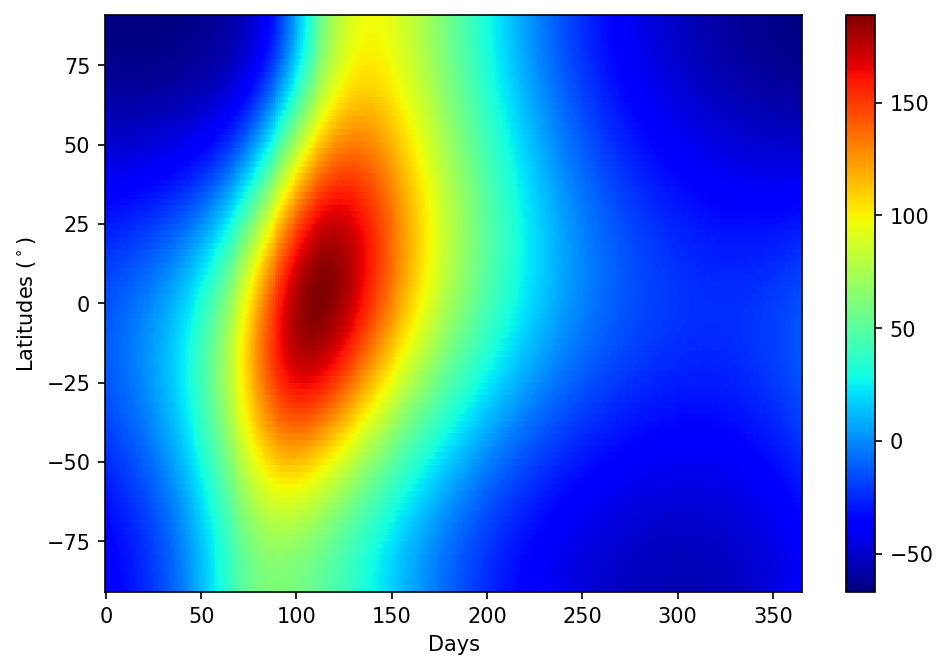

In [28]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
import matplotlib.cm as cm

X,Y,Z = np.genfromtxt('climlab_data.txt', delimiter = ',', comments = '#', unpack = True)

vmin = -67
vmax = 189
my_cmap = matplotlib.colormaps['jet']
norm = colors.Normalize(vmin,vmax)
cmmapable = cm.ScalarMappable(norm,my_cmap)
cmmapable.set_array(range(0,1))
my_cmap.set_over('w')
my_cmap.set_under('gray')

width = 5

fig = plt.figure(figsize=(1.5*width,width),dpi=150)
ax = fig.add_subplot(111)

zi = griddata((X,Y),Z,(orbits[None,:],lat[:,None]),method='nearest')
if plot_type == 'c':
  CS = ax.contour(orbits,lat,zi,levels=np.arange(vmin,vmax,width),cmap=my_cmap,vmin=vmin,vmax=vmax)
if plot_type == 'm':
  CS = ax.pcolormesh(orbits,lat,zi,cmap=my_cmap,vmin=vmin,vmax=vmax)
plt.colorbar(CS);
ax.set_ylabel("Latitudes $(^\circ)$", fontsize = 10)

if typea == 's':
  ax.set_xlabel("Days", fontsize = 10)
if typea == 'a':
  ax.set_xlabel("Orbits", fontsize = 10)
